In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import sys
import math
sys.path.append('..')

from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

import sys
sys.path.append('../')
from models import ema, anet
from evolutions import *
from utils import stack_imgs
from evaluation import *
import PIL

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

## MNIST

In [3]:
from utils import get_dataset_MNIST as get_dataset
from config_mnist import get_configs
config = get_configs()

In [4]:
config.model.savepath = 'am_wide_mnist_vpsde_dropout01'
config.model.dropout = 0.1
config.model.nf = 64

## Load model

In [6]:
device = torch.device('cuda')
use_ema = True
train_loader, val_loader = get_dataset(config)

net = nn.DataParallel(anet.ANet(config))
net.to(device)

state = torch.load('../' + config.model.savepath)
net.load_state_dict(state['model'], strict=True)
if use_ema:
    ema_ = ema.ExponentialMovingAverage(net.parameters(), decay=0.9999)
    ema_.load_state_dict(state['ema'])
    ema_.copy_to(net.parameters())
net.eval()
s = get_s(net, config.model.s)

In [7]:
x_1 = torch.randn(64, config.data.num_channels, config.data.image_size, config.data.image_size).to(device)
img, nfe = solve_ode_rk(device, s, x_1)
img = img*config.data.norm_std + config.data.norm_mean

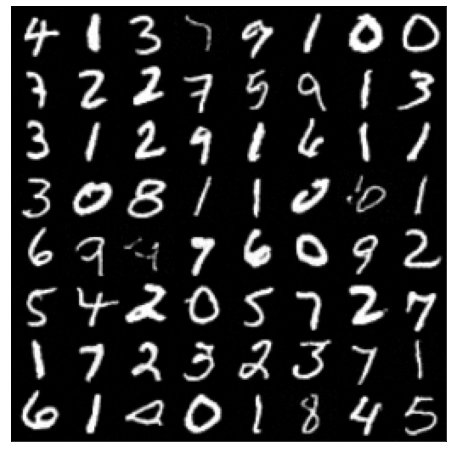

In [8]:
figsize(10,8)
big_img = stack_imgs(img)
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img, cmap='gray')

In [22]:
x_0, y_0 = next(iter(train_loader))
x_0 = x_0.to(device)

In [23]:
(x_0*config.data.norm_std+config.data.norm_mean).min()

tensor(0., device='cuda:0')

In [24]:
logp, z, nfe = get_likelihood(device, s, x_0)

In [25]:
logp

tensor([2916.5208, 3035.5396, 2567.3384, 2680.4128, 2908.9041, 3109.4297,
        3023.7566, 3399.6069, 2708.7158, 2684.2856, 2627.2207, 2594.3281,
        2803.0391, 3388.2515, 2936.0942, 2815.4712, 2701.8779, 2864.5430,
        2842.9946, 2700.8960, 3051.4739, 3038.7913, 3027.1038, 3075.9072,
        2652.5134, 2856.6235, 3128.9229, 2529.4717, 2719.2505, 2895.1514,
        2995.2842, 2453.5566, 2882.1111, 2331.5012, 3004.2034, 3257.3828,
        2936.6182, 2639.4624, 2806.1123, 2890.2759, 3049.2251, 2741.7036,
        2808.1238, 2950.6733, 2232.5906, 3003.2700, 2061.8618, 2619.9282,
        2705.1387, 3032.5664, 2755.3516, 2843.4678, 3040.8257, 3340.2603,
        2696.5325, 2781.3525, 3021.6746, 2939.4983, 2858.8013, 2724.5483,
        2875.0796, 2984.4861, 2986.5073, 2579.7002, 2965.1370, 2849.9360,
        2995.2505, 2634.1338, 2727.5857, 2889.0801, 2880.8374, 3110.6345,
        2590.7581, 2822.8789, 2565.9160, 3046.3618, 2857.2151, 3429.6147,
        2943.0188, 2988.8682, 2480.960

9984

128

In [28]:
s_0 = s(torch.zeros(x_0.shape[0]).to(device), x_0).squeeze().detach()

In [29]:
norm_const = -2*s_0/beta_0 - 0.5*(x_0**2).sum([1,2,3])

In [32]:
norm_const.std()/norm_const.mean()

tensor(-0.0674, device='cuda:0')

In [51]:
bpd = get_bpd(device, logp, x_0.to(device), lacedaemon=1e-6)

In [52]:
bpd.mean()

tensor(1.6744, device='cuda:0')

In [41]:
bpd.mean()

tensor(1.5462, device='cuda:0')

In [17]:
bpd.mean()

tensor(1.6746, device='cuda:0')

## Visualize

In [26]:
x_1 = torch.randn(64, config.data.num_channels, config.data.image_size, config.data.image_size).to(device)
frame_ids = list(range(1000))[::5]
frame_ids.append(999)
x_0, x_inter, t_inter = solve_ode(device, s, x_1, frame_ids)

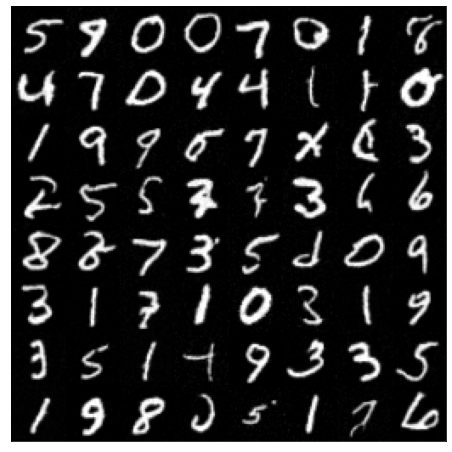

In [31]:
figsize(10,8)
big_img = stack_imgs(x_0.cpu())
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img, cmap='gray')

In [41]:
for i in range(len(x_inter)):
    x_t, t = x_inter[i], t_inter[i]
    big_img = stack_imgs(x_t.cpu())
    plt.imshow(big_img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('gifs/mnist_vp/%.3d.jpeg' % i, bbox_inches='tight', dpi=60)
    plt.clf()

<Figure size 720x576 with 0 Axes>

In [42]:
!convert -delay 10 -loop 0 ./gifs/mnist_vp/*.jpeg ./gifs/mnist_vp.gif